<a href="https://colab.research.google.com/github/onsSK/stage/blob/main/stage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import os
import pandas as pd
import cv2
from skimage.transform import rescale, resize
from tensorflow import keras
import numpy as np
from sklearn.utils import class_weight

import pickle
from skimage.io import imread
from sklearn.utils import shuffle
from matplotlib import pyplot as plt

In [2]:
#import pathlib

#dataset_url = "C:/Users/dell/Downloads/MURA-v1.1/train/XR_SHOULDER/study1_positive/image1.png"

#To get the filenames for a task
def filenames(part,train=True):
    root='/content/drive/MyDrive/MURA-v1.1'
    if train:
        csv_path="/content/drive/MyDrive/MURA-v1.1/train_image_paths.csv"
    else:
        csv_path="/content/drive/MyDrive/MURA-v1.1/valid_image_paths.csv"

    with open(csv_path, 'rb') as F:
        d = F.readlines()
        if part == 'all':
            imgs = [root + str(x, encoding='utf-8').strip() for x in d]
            imgs = [root + str(x, encoding='utf-8').strip() for x in d if
                            str(x, encoding='utf-8').strip().split('/')[2] == part]


    labels= [x.split('_')[-1].split('/')[0] for x in imgs]
    return imgs,labels


#To icrop a image from center
def crop_center(img,cropx,cropy):
    y,x,_ = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)
    return img[starty:starty+cropy,startx:startx+cropx]


In [3]:
!pip install albumentations


In [4]:
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightnessContrast, RandomGamma,
    ToFloat, ShiftScaleRotate
)
from albumentations import Resize


AUGMENTATIONS_TRAIN = Compose([
    HorizontalFlip(p=0.5),
    RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    RandomGamma(gamma_limit=(80, 120), p=0.5),
    ShiftScaleRotate(
        shift_limit=0.0625, scale_limit=0.1,
        rotate_limit=15, border_mode=cv2.BORDER_REFLECT_101, p=0.8),
    ToFloat(max_value=255)
])

AUGMENTATIONS_TEST = Compose([
    # CLAHE(p=1.0, clip_limit=2.0),
    ToFloat(max_value=255)
])


Horizontal Flip applied
RandomBrightnessContrast applied


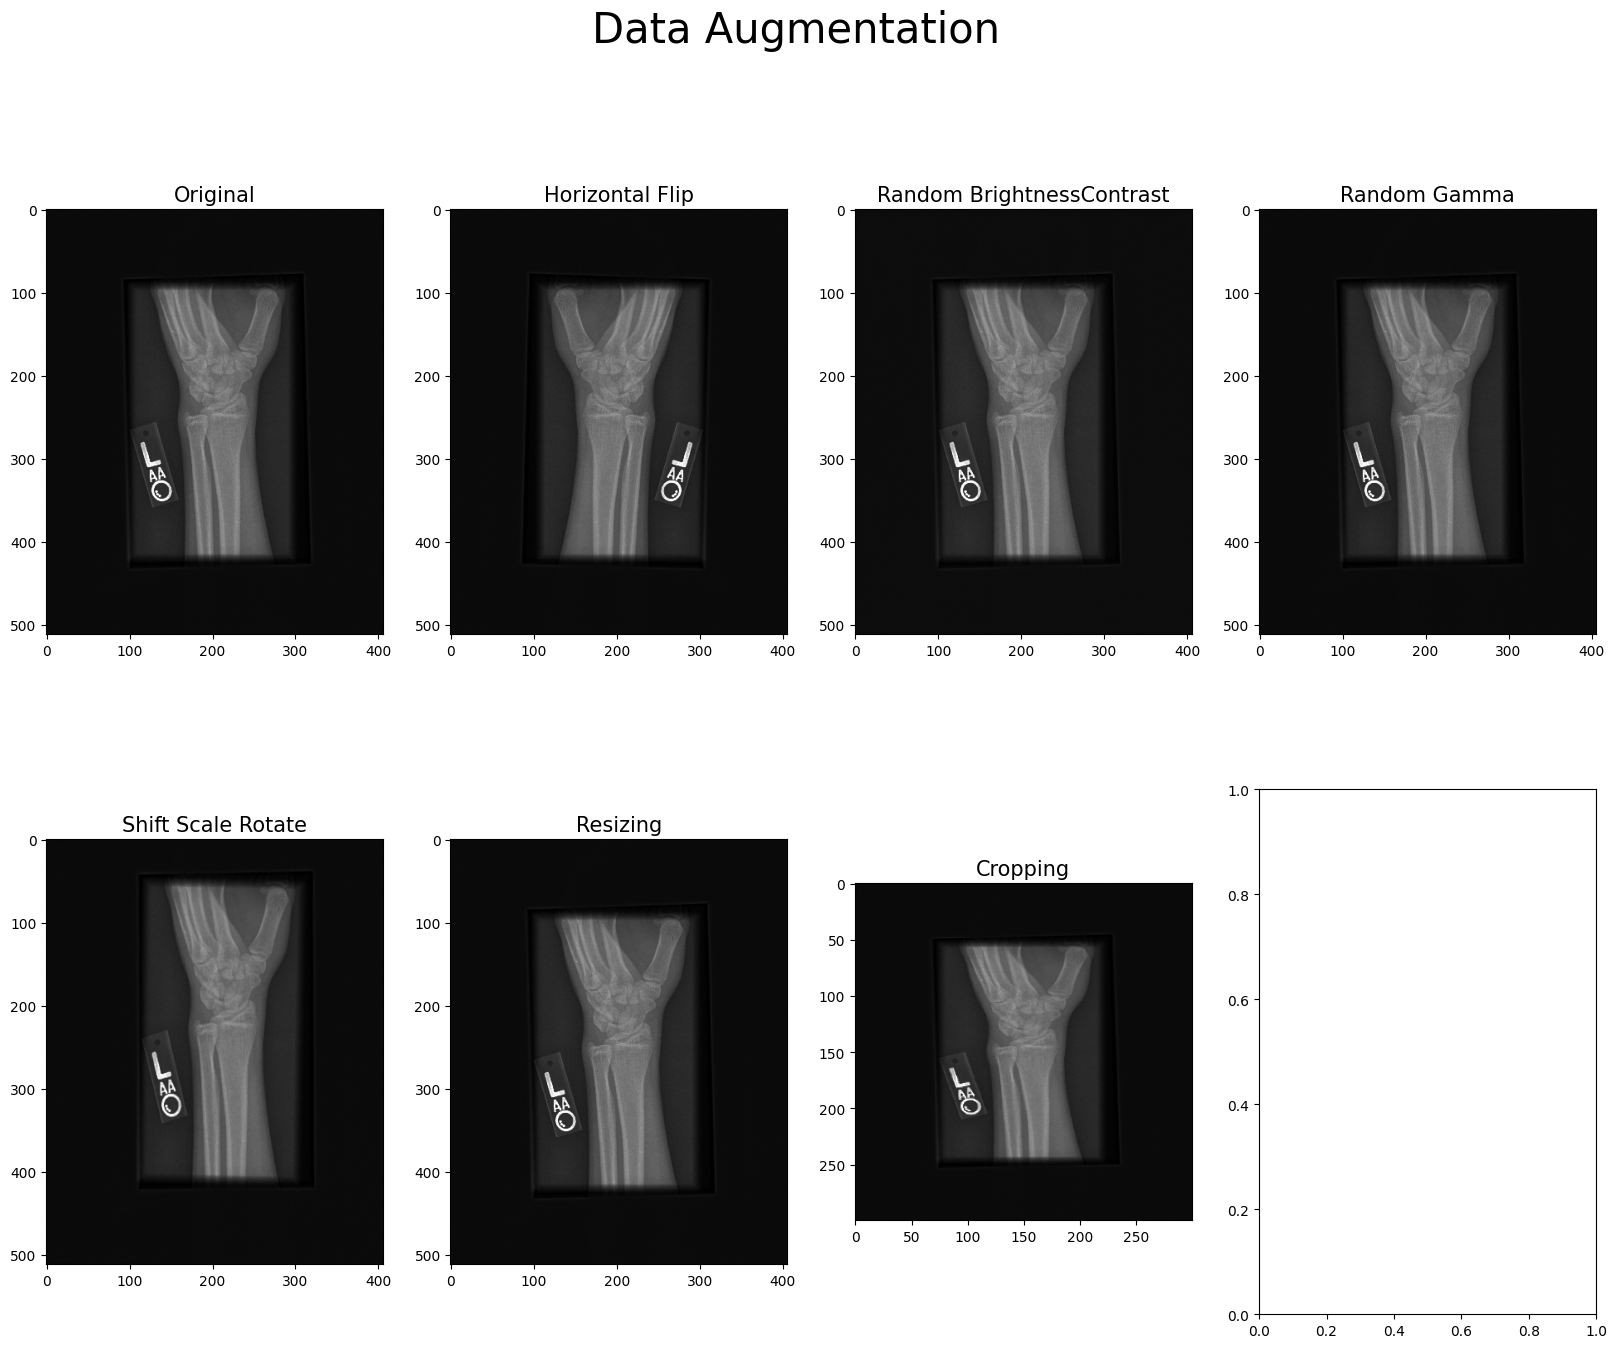

In [5]:
import os
import cv2
import matplotlib.pyplot as plt
from albumentations import (
    Compose, HorizontalFlip, RandomBrightnessContrast, RandomGamma,
    ShiftScaleRotate, ToFloat
)
from skimage.io import imread
from skimage.transform import resize

# Define Albumentations augmentations
albumentation_list =  [
    HorizontalFlip(p=1.0),  # Ensure flip is always applied for testing
    RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1.0),  # Ensure always applied
    RandomGamma(gamma_limit=(80, 120), p=0.5),
    ShiftScaleRotate(
        shift_limit=0.0625, scale_limit=0.1,
        rotate_limit=15, border_mode=cv2.BORDER_REFLECT_101, p=0.8),
    ToFloat(max_value=255)
]

# Define the image path and read the image
image_path = '/content/drive/MyDrive/MURA-v1.1/train/XR_WRIST/patient09082/study1_negative/image3.png'
chosen_image = imread(image_path)

# Placeholder for augmented images
img_matrix_list = []

# Apply each augmentation with debugging
for aug_type in albumentation_list:
    augmented = aug_type(image=chosen_image)
    img = augmented['image']
    if aug_type.__class__.__name__ == 'HorizontalFlip':
        print("Horizontal Flip applied")
    if aug_type.__class__.__name__ == 'RandomBrightnessContrast':
        print("RandomBrightnessContrast applied")
    img_matrix_list.append(img)

# Add resized and cropped versions of the image
img_resized = resize(chosen_image, (300, 300, 3))
img_matrix_list.append(img_resized)

def crop_center(image, cropx, cropy):
    y, x, _ = image.shape
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)
    return image[starty:starty+cropy, startx:startx+cropx]

img_cropped = crop_center(img_resized, 224, 224)
img_matrix_list.append(img_cropped)

# Add the original image at the beginning
img_matrix_list.insert(0, chosen_image)

# Titles for the plots
titles_list = ["Original", "Horizontal Flip", "Random BrightnessContrast", "Random Gamma",
               "Shift Scale Rotate", "Resizing", "Cropping"]

# Function to plot multiple images
def plot_multiple_img(img_matrix_list, title_list, ncols, main_title="Data Augmentation"):
    fig, myaxes = plt.subplots(figsize=(20, 15), nrows=2, ncols=ncols, squeeze=True)
    fig.suptitle(main_title, fontsize=30)
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize=15)
    plt.show()

# Plot the images
plot_multiple_img(img_matrix_list, titles_list, ncols=4)


In [6]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
class My_Custom_Generator(keras.utils.Sequence) :

  def __init__(self, image_filenames, labels, batch_size,transform) :
    self.image_filenames = image_filenames
    self.labels = labels
    self.batch_size = batch_size
    self.t= transform

  def __len__(self) :
    return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)


  def __getitem__(self, idx) :
    batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
    x=[]
    for file in batch_x:
        img= imread(file)
        img= self.t(image=img)["image"]
        img= resize(img,(300,300,3))
        img= crop_center(img,224,224)
        x.append(img)
    x=np.array(x)/255.0
    y= np.array(batch_y)
    return x,y

In [7]:
import pandas as pd
from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical

# Load the CSV files
train_image_paths_df = pd.read_csv('/content/drive/MyDrive/MURA-v1.1/train_image_paths.csv', header=None, names=['image_path'])
train_labels_df = pd.read_csv('/content/drive/MyDrive/MURA-v1.1/train_labeled_studies.csv', header=None, names=['image_path', 'label'])
valid_image_paths_df = pd.read_csv('/content/drive/MyDrive/MURA-v1.1/valid_image_paths.csv', header=None, names=['image_path'])
valid_labels_df = pd.read_csv('/content/drive/MyDrive/MURA-v1.1/valid_labeled_studies.csv', header=None, names=['image_path', 'label'])

# Display the first few rows to check the structure
print("Train Image Paths:")
print(train_image_paths_df.head())
print("Train Labels:")
print(train_labels_df.head())
print("Validation Image Paths:")
print(valid_image_paths_df.head())
print("Validation Labels:")
print(valid_labels_df.head())

# Function to filter image paths and labels based on part
def get_filenames_and_labels(part, image_paths_df, labels_df):
    # Filter image paths based on part
    filtered_paths_df = image_paths_df[image_paths_df['image_path'].str.contains(part)]

    # Extract image paths
    imgs = filtered_paths_df['image_path'].tolist()

    # Extract corresponding labels
    labels = []
    for img_path in imgs:
        label_row = labels_df[labels_df['image_path'] == img_path]
        if not label_row.empty:
            labels.append(label_row['label'].values[0])
        else:
            labels.append(None)  # Handle missing label case

    return imgs, labels

# Example usage for training data
part = 'XR_WRIST'
train_imgs, train_labels = get_filenames_and_labels(part, train_image_paths_df, train_labels_df)

# Example usage for validation data
valid_imgs, valid_labels = get_filenames_and_labels(part, valid_image_paths_df, valid_labels_df)

print(f"Training data: {len(train_labels)}")
print(f"Validation data: {len(valid_labels)}")




Train Image Paths:
                                          image_path
0  MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1  MURA-v1.1/train/XR_SHOULDER/patient00001/study...
2  MURA-v1.1/train/XR_SHOULDER/patient00001/study...
3  MURA-v1.1/train/XR_SHOULDER/patient00002/study...
4  MURA-v1.1/train/XR_SHOULDER/patient00002/study...
Train Labels:
                                          image_path  label
0  MURA-v1.1/train/XR_SHOULDER/patient00001/study...      1
1  MURA-v1.1/train/XR_SHOULDER/patient00002/study...      1
2  MURA-v1.1/train/XR_SHOULDER/patient00003/study...      1
3  MURA-v1.1/train/XR_SHOULDER/patient00004/study...      1
4  MURA-v1.1/train/XR_SHOULDER/patient00005/study...      1
Validation Image Paths:
                                          image_path
0  MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
1  MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
2  MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
3  MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...


In [8]:

# Define the string you want to search for
search_string = 'positive'

# Search for the string in the entire DataFrame
# This will create a boolean DataFrame where True indicates the presence of the search string
mask = train_image_paths_df.applymap(lambda x: search_string in str(x))

# Extract rows that contain the search string
matching_rows = train_image_paths_df[mask.any(axis=1)]

# Display the matching rows
print(matching_rows)

#  saving the matching rows to a new CSV file
matching_rows.to_csv('filtered_dataset.csv', index=False)


                                              image_path
0      MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1      MURA-v1.1/train/XR_SHOULDER/patient00001/study...
2      MURA-v1.1/train/XR_SHOULDER/patient00001/study...
3      MURA-v1.1/train/XR_SHOULDER/patient00002/study...
4      MURA-v1.1/train/XR_SHOULDER/patient00002/study...
...                                                  ...
32820  MURA-v1.1/train/XR_HAND/patient10136/study1_po...
32821  MURA-v1.1/train/XR_HAND/patient10136/study1_po...
32822  MURA-v1.1/train/XR_HAND/patient10137/study1_po...
32823  MURA-v1.1/train/XR_HAND/patient10137/study1_po...
32824  MURA-v1.1/train/XR_HAND/patient10137/study1_po...

[14873 rows x 1 columns]


<ipython-input-8-a7db78f1ac93>:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mask = train_image_paths_df.applymap(lambda x: search_string in str(x))


In [9]:
# Define the string you want to search for
search_string = 'negative'

# Search for the string in the entire DataFrame
# This will create a boolean DataFrame where True indicates the presence of the search string
mask = train_image_paths_df.applymap(lambda x: search_string in str(x))

# Extract rows that contain the search string
matching_rows = train_image_paths_df[mask.any(axis=1)]

# Display the matching rows
print(matching_rows)
5
# If you want to save the matching rows to a new CSV file
matching_rows.to_csv('filtered_dataset1.csv', index=False)

                                              image_path
19     MURA-v1.1/train/XR_SHOULDER/patient00007/study...
20     MURA-v1.1/train/XR_SHOULDER/patient00007/study...
21     MURA-v1.1/train/XR_SHOULDER/patient00007/study...
22     MURA-v1.1/train/XR_SHOULDER/patient00007/study...
155    MURA-v1.1/train/XR_SHOULDER/patient00051/study...
...                                                  ...
36803  MURA-v1.1/train/XR_HAND/patient11183/study1_ne...
36804  MURA-v1.1/train/XR_HAND/patient11183/study1_ne...
36805  MURA-v1.1/train/XR_HAND/patient11184/study1_ne...
36806  MURA-v1.1/train/XR_HAND/patient11184/study1_ne...
36807  MURA-v1.1/train/XR_HAND/patient11184/study1_ne...

[21935 rows x 1 columns]


<ipython-input-9-42d66342d2f7>:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mask = train_image_paths_df.applymap(lambda x: search_string in str(x))


In [10]:
import pandas as pd

# Load the CSV file into a DataFrame without headers
df = pd.read_csv('/content/drive/MyDrive/MURA-v1.1/train_image_paths.csv', header=None)

# Display the first few rows and the columns to ensure the correct structure
print(df.head())
print(df.columns)

# Ensure the DataFrame has columns
if df.empty or df.shape[1] == 0:
    raise ValueError("The CSV file appears to be empty or not properly loaded.")

# Define the start position
start_pos = 16

# Define the end character
end_char = '/p'

# Define a function to extract the substring
def extract_substring(value, start, end_char):
    # Convert the value to a string
    value_str = str(value)
    # Find the end position based on the end character
    end_pos = value_str.find(end_char, start)
    # If the end character is not found, use the rest of the string
    if end_pos == -1:
        return value_str[start:]
    # Extract the substring
    return value_str[start:end_pos]

# Apply the function to the first column and create a new column with the extracted substrings
df['category'] = df.iloc[:, 0].apply(lambda x: extract_substring(x, start_pos, end_char))

# Display the DataFrame with the new column
print(df.head())








                                                   0
0  MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1  MURA-v1.1/train/XR_SHOULDER/patient00001/study...
2  MURA-v1.1/train/XR_SHOULDER/patient00001/study...
3  MURA-v1.1/train/XR_SHOULDER/patient00002/study...
4  MURA-v1.1/train/XR_SHOULDER/patient00002/study...
Index([0], dtype='int64')
                                                   0     category
0  MURA-v1.1/train/XR_SHOULDER/patient00001/study...  XR_SHOULDER
1  MURA-v1.1/train/XR_SHOULDER/patient00001/study...  XR_SHOULDER
2  MURA-v1.1/train/XR_SHOULDER/patient00001/study...  XR_SHOULDER
3  MURA-v1.1/train/XR_SHOULDER/patient00002/study...  XR_SHOULDER
4  MURA-v1.1/train/XR_SHOULDER/patient00002/study...  XR_SHOULDER


In [11]:
# Load the CSV file into a DataFrame without headers
df = pd.read_csv('/content/drive/MyDrive/MURA-v1.1/train_image_paths.csv', header=None)

# Define the start position and the end character
start_pos = 16  # Adjusted to correctly extract "XR_SHOULDER"
end_char = '/p'

# Define a function to extract the substring
def extract_substring(value, start, end_char):
    value_str = str(value)
    end_pos = value_str.find(end_char, start)
    if end_pos == -1:
        return value_str[start:]
    return value_str[start:end_pos]

# Apply the function to the first column and create a new column with the extracted substrings
df['extracted_string'] = df[0].apply(lambda x: extract_substring(x, start_pos, end_char))

# Display only the 'extracted_string' column
print(df['extracted_string'].head())

# Save only the 'extracted_string' column to a new CSV file
df['extracted_string'].to_csv('extracted_strings.csv', index=False, header=False)


0    XR_SHOULDER
1    XR_SHOULDER
2    XR_SHOULDER
3    XR_SHOULDER
4    XR_SHOULDER
Name: extracted_string, dtype: object


In [12]:

dff = pd.read_csv('extracted_strings.csv', header=None)
categories_counts = pd.DataFrame(dff.value_counts())
print ('\n\ncategories:\n',categories_counts )



categories:
              count
0                 
XR_WRIST      9752
XR_SHOULDER   8379
XR_HAND       5543
XR_FINGER     5106
XR_ELBOW      4931
XR_FOREARM    1825
XR_HUMERUS    1272


In [13]:
import tensorflow as tf
print(tf.__version__)



2.17.0


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

idg_train_settings = dict(samplewise_center = True,
                         samplewise_std_normalization = True,
                          rotation_range = 5,
                          width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         zoom_range = 0.1,
                         horizontal_flip = True,
                         vertical_flip = True)
idg_train = ImageDataGenerator(**idg_train_settings)

idg_valid_settings = dict(samplewise_center = True,
                         samplewise_std_normalization = True,
                          rotation_range = 0,
                          width_shift_range = 0.,
                         height_shift_range = 0.,
                         zoom_range = 0.0,
                         horizontal_flip = False,
                         vertical_flip = False)
idg_valid = ImageDataGenerator(**idg_valid_settings)

In [15]:
# Load the CSV file into a DataFrame without headers
df1 = pd.read_csv('/content/drive/MyDrive/MURA-v1.1/train_labeled_studies.csv', header=None)

# Display the first few rows to verify the DataFrame
print(df1.head())

# Extract the second column (index 1) which contains the labels
labels = df1.iloc[:, 1]

# Display the first few labels to verify extraction
print(labels.head())

# Save the labels to a new CSV file
labels.to_csv('extracted_labels.csv', index=False, header=False)



                                                   0  1
0  MURA-v1.1/train/XR_SHOULDER/patient00001/study...  1
1  MURA-v1.1/train/XR_SHOULDER/patient00002/study...  1
2  MURA-v1.1/train/XR_SHOULDER/patient00003/study...  1
3  MURA-v1.1/train/XR_SHOULDER/patient00004/study...  1
4  MURA-v1.1/train/XR_SHOULDER/patient00005/study...  1
0    1
1    1
2    1
3    1
4    1
Name: 1, dtype: int64


In [16]:
train_image_paths_df['patientId']  = train_image_paths_df['image_path'].apply(lambda x: x.split('/')[3].replace('patient',''))

train_image_paths_df.head()

,image_path,patientId
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,00001
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,00001
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,00001
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,00002
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,00002


In [17]:
# Define a function to extract the category from the image path
def extract_category(image_path):
    # Adjust the start_pos based on the common structure of the image paths
    start_pos = image_path.find('train/') + len('train/')
    end_pos = image_path.find('/', start_pos)
    return image_path[start_pos:end_pos]


# Apply the function to the 'image_path' column to create a new 'category' column
train_image_paths_df['category'] = train_image_paths_df['image_path'].apply(extract_category)
train_image_paths_df['label'] = train_image_paths_df['image_path'].map(lambda x:'positive' if 'positive' in x else 'negative')
# Display the DataFrame with the new column to verify
print(train_image_paths_df.head())

# Save the updated DataFrame to a new CSV file
train_image_paths_df.to_csv('updated_dataset.csv', index=False)



                                          image_path patientId     category  \
0  MURA-v1.1/train/XR_SHOULDER/patient00001/study...     00001  XR_SHOULDER   
1  MURA-v1.1/train/XR_SHOULDER/patient00001/study...     00001  XR_SHOULDER   
2  MURA-v1.1/train/XR_SHOULDER/patient00001/study...     00001  XR_SHOULDER   
3  MURA-v1.1/train/XR_SHOULDER/patient00002/study...     00002  XR_SHOULDER   
4  MURA-v1.1/train/XR_SHOULDER/patient00002/study...     00002  XR_SHOULDER   

      label  
0  positive  
1  positive  
2  positive  
3  positive  
4  positive  


In [18]:
# Define a function to extract the category from the image path
def extract_category(image_path):
    # Adjust the start_pos based on the common structure of the image paths
    start_pos = image_path.find('train/') + len('train/')
    end_pos = image_path.find('/', start_pos)
    return image_path[start_pos:end_pos]

def extract_patientId(image_path):
    # Adjust the start_pos based on the common structure of the image paths
    start_pos = image_path.find('/patient') + len('/patient')
    end_pos = image_path.find('/', start_pos)
    return image_path[start_pos:end_pos]

# Apply the function to the 'image_path' column to create a new 'category' column
train_labels_df['category'] = train_labels_df['image_path'].apply(extract_category)
train_labels_df['patientId'] = train_labels_df['image_path'].apply(extract_patientId)

# Display the DataFrame with the new column to verify
print(train_labels_df.head())

# Save the updated DataFrame to a new CSV file
train_labels_df.to_csv('updated_dataset1.csv', index=False)



                                          image_path  label     category  \
0  MURA-v1.1/train/XR_SHOULDER/patient00001/study...      1  XR_SHOULDER   
1  MURA-v1.1/train/XR_SHOULDER/patient00002/study...      1  XR_SHOULDER   
2  MURA-v1.1/train/XR_SHOULDER/patient00003/study...      1  XR_SHOULDER   
3  MURA-v1.1/train/XR_SHOULDER/patient00004/study...      1  XR_SHOULDER   
4  MURA-v1.1/train/XR_SHOULDER/patient00005/study...      1  XR_SHOULDER   

  patientId  
0     00001  
1     00002  
2     00003  
3     00004  
4     00005  


In [19]:
total_number_of_training_images = np.shape(train_image_paths_df)[0]
print("total number of images:",total_number_of_training_images )
print ("\n\nnumber of null values", train_image_paths_df.isnull().sum())
print("\n\nnumber of training images:",np.shape(train_image_paths_df['image_path'])[0])



categories_counts = pd.DataFrame(train_image_paths_df['category'].value_counts())
print ('\n\ncategories:\n',categories_counts )
print('\n\nnumber of labels:',train_image_paths_df['label'].nunique())
print ('\n\npositive cases:',len(train_image_paths_df[train_image_paths_df['label']=='positive']))
print ('\n\nnegative cases:',len(train_image_paths_df[train_image_paths_df['label']=='negative']))

total number of images: 36808


number of null values image_path    0
patientId     0
category      0
label         0
dtype: int64


number of training images: 36808


categories:
              count
category          
XR_WRIST      9752
XR_SHOULDER   8379
XR_HAND       5543
XR_FINGER     5106
XR_ELBOW      4931
XR_FOREARM    1825
XR_HUMERUS    1272


number of labels: 2


positive cases: 14873


negative cases: 21935


In [20]:
valid_image_paths_df['label'] = valid_image_paths_df['image_path'].map(lambda x:'positive' if 'positive' in x else 'negative')
valid_image_paths_df['category']  = valid_image_paths_df['image_path'].apply(lambda x: x.split('/')[2])
valid_image_paths_df['dir'] =  valid_image_paths_df['image_path'].apply(lambda x: x.split('/')[1])
valid_image_paths_df['patientId']  = valid_image_paths_df['image_path'].apply(lambda x: x.split('/')[3].replace('patient',''))
valid_image_paths_df.head()

,image_path,label,category,dir,patientId
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,positive,XR_WRIST,valid,11186


In [21]:
print("data_shape:",np.shape(valid_image_paths_df))
print ("\n\nnumber of null values", valid_image_paths_df.isnull().sum())
print("\n\nnumber of training images:",np.shape(valid_image_paths_df['image_path']))

validaton_categories_counts = pd.DataFrame(valid_image_paths_df['category'].value_counts())
print ('\n\ncategories:\n',validaton_categories_counts)
print('\n\nnumber of patients:',valid_image_paths_df['patientId'].nunique())
print('\n\nnumber of labels:',valid_image_paths_df['label'].nunique())
print ('\n\npositive casses:',len(valid_image_paths_df[valid_image_paths_df['label']=='positive']))
print ('\n\nnegative casses:',len(valid_image_paths_df[valid_image_paths_df['label']=='negative']))

data_shape: (3197, 5)


number of null values image_path    0
label         0
category      0
dir           0
patientId     0
dtype: int64


number of training images: (3197,)


categories:
              count
category          
XR_WRIST       659
XR_SHOULDER    563
XR_ELBOW       465
XR_FINGER      461
XR_HAND        460
XR_FOREARM     301
XR_HUMERUS     288


number of patients: 783


number of labels: 2


positive casses: 1530


negative casses: 1667


In [22]:
train_image_paths_df['label'] = train_image_paths_df['image_path'].map(lambda x:'positive' if 'positive' in x else 'negative')

train_image_paths_df['category']  = train_image_paths_df['image_path'].apply(lambda x: x.split('/')[2])
train_image_paths_df['patientId']  = train_image_paths_df['image_path'].apply(lambda x: x.split('/')[3].replace('patient',''))
train_image_paths_df.head()

,image_path,patientId,category,label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,00001,XR_SHOULDER,positive
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,00001,XR_SHOULDER,positive
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,00001,XR_SHOULDER,positive
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,00002,XR_SHOULDER,positive
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,00002,XR_SHOULDER,positive


<Axes: >

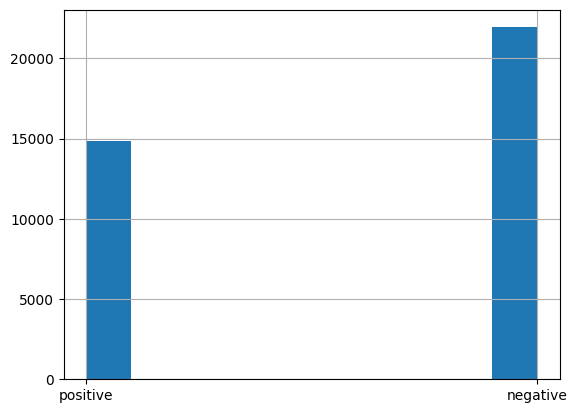

In [23]:
category = 'XR_WRIST'
train_mask = train_image_paths_df['category'] == category
valid_mask = valid_image_paths_df['category']==category
train_df_of_cat = train_image_paths_df
valid_df_of_cat = valid_image_paths_df
train_df_of_cat['label'].hist()

In [24]:
!pip install tensorflow_addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.0 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.3.1 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.io import imread
from skimage.transform import resize
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Fonction pour extraire les chemins des images et leurs labels
def extract_image_paths_and_labels(base_dir, subset):
    data = []
    categories_path = os.path.join(base_dir, subset)

    # Vérifie si le répertoire existe
    if not os.path.exists(categories_path):
        raise FileNotFoundError(f"Le répertoire {categories_path} n'existe pas")

    categories = os.listdir(categories_path)
    for category in categories:
        category_path = os.path.join(categories_path, category)
        patients = os.listdir(category_path)
        for patient in patients:
            patient_path = os.path.join(category_path, patient)
            studies = os.listdir(patient_path)
            for study in studies:
                study_path = os.path.join(patient_path, study)
                label = 'positive' if 'positive' in study else 'negative'
                images = os.listdir(study_path)
                for image in images:
                    # Ignore les fichiers non valides (ex. : fichiers de métadonnées macOS)
                    if image.startswith('._'):
                        continue
                    image_path = os.path.join(study_path, image)
                    # Vérifie si le fichier est une image valide
                    try:
                        with Image.open(image_path) as img:
                            img.verify()
                        data.append({'image_path': image_path, 'label': label})
                    except (IOError, SyntaxError):
                        print(f"Fichier image invalide : {image_path}")
    return pd.DataFrame(data)

# Définir le répertoire de base
base_dir = '/content/drive/MyDrive/MURA-v1.1'

# Extraire les chemins et labels pour les ensembles d'entraînement et de validation
train_image_paths_df = extract_image_paths_and_labels(base_dir, 'train')
valid_image_paths_df = extract_image_paths_and_labels(base_dir, 'valid')

# Initialiser les générateurs d'images pour l'entraînement et la validation
train_datagen = ImageDataGenerator(rescale=1.0/255.0)  # Correction du facteur de rescaling
valid_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Créer des générateurs à partir des DataFrames
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_image_paths_df,
    x_col='image_path',
    y_col='label',
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_image_paths_df,
    x_col='image_path',
    y_col='label',
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

# Vérifier si les générateurs ont chargé les données
print(f"Nombre d'échantillons d'entraînement : {train_generator.samples}")
print(f"Nombre d'échantillons de validation : {valid_generator.samples}")





In [ ]:
a, b = next(train_generator)
i,l = next(valid_generator)
print("training input images patch shape  : ", a.shape)
print("training input labels patch shape  : ",b.shape)
print("training labels:",train_generator.class_indices)
print ("________________________________________")
print("validation input images patch shape: ", a.shape)

print("validation input images patch shape: ", i.shape)
print("validation input labels patch shape: ",b.shape)
print("validation labels:",valid_generator.class_indices)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import AUC, BinaryAccuracy
from tensorflow.keras.regularizers import l2

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),  # Regularization applied here
    Dropout(0.5),  # Dropout applied here
    Dense(1, activation='sigmoid')  # Final output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', AUC(), BinaryAccuracy()])

# Training the model
epochs = 10

checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=valid_generator,
    callbacks=[checkpoint, early_stopping]
)


In [ ]:
import matplotlib.pyplot as plt


# Tracer les courbes de perte
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Courbes de perte')
plt.xlabel('Epoch')
plt.ylabel('Perte')
plt.legend()
plt.show()

# Tracer les courbes de précision
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Courbes de précision')
plt.xlabel('Epoch')
plt.ylabel('Précision')
plt.legend()
plt.show()

In [ ]:
!pip install flask==2.0.3 pyngrok==5.1.0


In [ ]:
!pip install --upgrade Flask


In [ ]:
!pip install werkzeug==2.0.3


In [ ]:
!pip install --upgrade --force-reinstall Flask


In [ ]:
from flask import Flask, request, jsonify
import numpy as np
from PIL import Image

app = Flask(__name__)



def preprocess_image(image):
    image = image.resize((128, 128))
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    return image

@app.route('/predict', methods=['POST'])
def predict():
    file = request.files['image']
    image = Image.open(file.stream)
    processed_image = preprocess_image(image)
    prediction = model.predict(processed_image).tolist()
    return jsonify({'prediction': prediction})

if __name__ == '__main__':
    app.run()


In [ ]:
!pip install flask pillow pyngrok tensorflow


In [ ]:
from flask import Flask, request, render_template_string

from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image
import io

app = Flask(__name__)


# Fonction pour prétraiter l'image
def preprocess_image(img):
    img = img.resize((128, 128))  # Redimensionner l'image à la taille attendue par le modèle
    img_array = np.array(img) / 255.0  # Normaliser les valeurs des pixels
    img_array = np.expand_dims(img_array, axis=0)  # Ajouter une dimension pour le batch
    return img_array

@app.route('/', methods=['GET', 'POST'])
def upload_file():
    if request.method == 'POST':
        if 'file' not in request.files:
            return 'No file part'
        file = request.files['file']
        if file.filename == '':
            return 'No selected file'
        if file:
            img = Image.open(io.BytesIO(file.read()))  # Lire l'image depuis le fichier
            img_array = preprocess_image(img)
            predictions = model.predict(img_array)
            class_label = 'positive' if predictions[0][0] > 0.5 else 'negative'
            return render_template_string('''
                <!DOCTYPE html>
                <html>
                <head>
                    <title>Classification Result</title>
                </head>
                <body>
                    <h1>Classification Result</h1>
                    <p>The image is classified as: {{ label }}</p>
                    <a href="/">Upload another image</a>
                </body>
                </html>
            ''', label=class_label)
    return '''
        <!DOCTYPE html>
        <html>
        <head>
            <title>Upload Image</title>
        </head>
        <body>
            <h1>Upload Image for Classification</h1>
            <form action="/" method="post" enctype="multipart/form-data">
                <input type="file" name="file" accept="image/*">
                <input type="submit" value="Upload Image">
            </form>
        </body>
        </html>
    '''

if __name__ == '__main__':
    app.run()


In [ ]:
from pyngrok import ngrok
import os

# Expose Flask app via ngrok
public_url = ngrok.connect(port='5000')
print(f" * ngrok tunnel \"{public_url}\" -> \"http://127.0.0.1:5000/\"")

# Start Flask application
!python app.py


In [ ]:
!wget -O /content/model.h5 "URL_TO_YOUR_MODEL_H5"
